In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import các mô hình và công cụ đánh giá từ scikit-learn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
roc_auc_score, roc_curve, confusion_matrix, classification_report

In [3]:
# Import thư viện PyTorch
import torch # Thư viện học sâu
import torchvision # Thư viện xử lý ảnh cho PyTorch
import torch.nn as nn # Các lớp mạng neural
import torch.optim as optim # Các thuật toán tối ưu hoá
import torch.nn.functional as F  # Các hàm kích hoạt và hàm mất mát
from torch.utils.data import DataLoader, TensorDataset # Công cụ xử lý dữ liệu

In [4]:
# Thiết lập thiết bị tính toán (GPU nếu có, nếu không thì CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Định nghĩa mô hình LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size # Số lớp đơn vị ẩn trong LSTM
        self.num_layers = num_layers # Số lớp LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # Lớp LSTM
        self.fc1 = nn.Linear(hidden_size * sequence_length, 128) # Lớp fully connected đầu tiên
        self.fc2 = nn.Linear(128, num_classes) # Lớp fully connected thứ hai
        self.dropout = nn.Dropout(0.4)  # Thêm dropout để tránh overfitting

    def forward(self, x):
        # Khởi tạo trạng thái ban đầu
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Truyền qua LSTM
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]

        # Truyền qua các lớp fully connected
        out = F.relu(self.fc1(out)) # Hàm kích hoạt ReLU
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [6]:
# Thiết lập tham số cho mô hình
input_size = 26          # Số đặc trưng đầu vào, tương ứng với kích thước đặc trưng của mỗi bước trong chuỗi
sequence_length = 1      # Chiều dài chuỗi, mỗi chuỗi có 32 bước
num_layers = 4           # Số lớp RNN
hidden_size = 256        # Số đơn vị ẩn trong lớp RNN
num_classes = 2          # Số lớp đầu ra (bài toán này có 2 lớp (YES or NO))
learning_rate = 0.0001   # Tốc độ học
batch_size = 1024        # Kích thước của mỗi batch
epochs = 200             # Số epoch huấn luyện

In [7]:
# Đặt seed cho PyTorch để đảm bảo khả năng tái tạo
torch.manual_seed(42)

In [8]:
# Đọc dữ liệu từ file parquet đã lưu ở file 2. Data Normalization
X_train = pd.read_parquet('X_train.parquet')
y_train = pd.read_parquet('y_train.parquet')

X_test = pd.read_parquet('X_test.parquet')
y_test = pd.read_parquet('y_test.parquet')

In [9]:
# Lưu tên các cột trong dữ liệu training
cols = X_train.columns

In [10]:
# Chuyển đổi dữ liệu đã augment thành tensor PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).view(-1, sequence_length, input_size).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).view(-1).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).view(-1, sequence_length, input_size).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).view(-1).to(device)

In [11]:
# Tạo DataLoader cho việc huấn luyện theo batch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [12]:
# Khởi tạo mô hình với các hyperparameters đã được định nghĩa
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

In [13]:
print(model)

LSTM(
  (lstm): LSTM(26, 256, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [14]:
# Định nghĩa hàm mất mát CrossEntropyLoss và bộ tối ưu hóa
criterion = nn.CrossEntropyLoss() # Hàm mất mát Cross Entropy
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5) # Thuật toán tối ưu hoá RMSprop

In [15]:
# Điều chỉnh bộ lập lịch học
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs) # Lập lịch giảm learning rate theo hàm cos

In [16]:
# Huấn luyện mô hình
losses = []
for epoch in range(epochs):
    model.train() # Đặt mô hình ở chế độ huấn luyện
    epoch_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass (lan truyền xuôi)
        scores = model(data)
        loss = criterion(scores, targets)
        epoch_loss += loss.item()

        # Backward pass (lan truyền ngược) và tối ưu hoá
        optimizer.zero_grad() # Đặt gradient về 0
        loss.backward() # Tính toán gradient

        # Gradient clipping để tránh exploding gradient (hiện tượng bộ dốc quá lớn)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        # Cập nhật trọng số
        optimizer.step()

    # Cập nhật learning rate
    scheduler.step()

    losses.append(epoch_loss / len(train_loader))

    # In kết quả mỗi 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}')


Epoch [10/200], Loss: 0.5020
Epoch [20/200], Loss: 0.4489
Epoch [30/200], Loss: 0.4388
Epoch [40/200], Loss: 0.4293
Epoch [50/200], Loss: 0.4247
Epoch [60/200], Loss: 0.4213
Epoch [70/200], Loss: 0.4238
Epoch [80/200], Loss: 0.4225
Epoch [90/200], Loss: 0.4202
Epoch [100/200], Loss: 0.4208
Epoch [110/200], Loss: 0.4183
Epoch [120/200], Loss: 0.4156
Epoch [130/200], Loss: 0.4197
Epoch [140/200], Loss: 0.4201
Epoch [150/200], Loss: 0.4155
Epoch [160/200], Loss: 0.4191
Epoch [170/200], Loss: 0.4161
Epoch [180/200], Loss: 0.4154
Epoch [190/200], Loss: 0.4170
Epoch [200/200], Loss: 0.4178


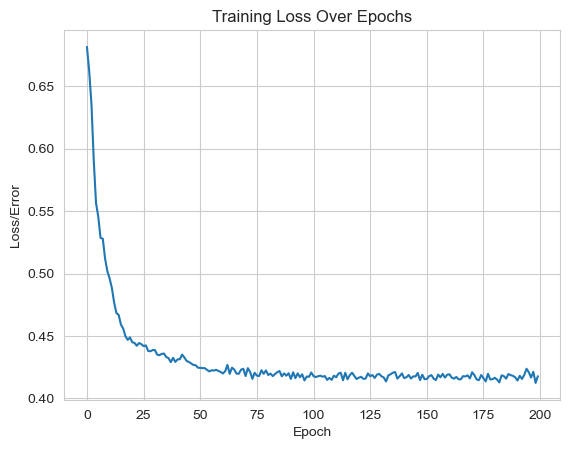

In [17]:
# Vẽ đồ thị độ mất mát qua các epochs
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss/Error')
plt.title('Training Loss Over Epochs')
plt.show()

In [18]:
# Đánh giá mô hình trên tập dữ liệu kiểm tra (validate model on test set)
model.eval() # Đặt mô hình ở chế độ đánh giá
with torch.no_grad(): # Về cơ bản tắt back propagation (tắt tính toán gradient descent)

    # Dự đoán trên tập kiểm tra
    y_eval = model.forward(X_test_tensor) # X_test_tensor là các đặc trưng từ tập kiểm tra, y_eval sẽ là các dự đoán

    # Tính độ mất mát trên tập kiểm tra
    loss = criterion(y_eval, y_test_tensor)

print(f'Test Loss: {loss.item():.4f}')

Test Loss: 0.3956


In [19]:
correct = 0
# Chuyển mô hình sang chế độ đánh giá
model.eval()
with torch.no_grad():
    for i in range(X_test_tensor.size(0)):
        y_val = model.forward(X_test_tensor[i].unsqueeze(0))  # Thêm unsqueeze(0) để thêm chiều cho dữ liệu
        if y_val.argmax().item() == y_test_tensor[i]:
            correct += 1
print(f'We got {correct}/{y_test.shape[0]}', '(',round((correct / y_test.shape[0] * 100), 2) , '% )', 'correct!')

We got 1154/1409 ( 81.9 % ) correct!


In [20]:
# Chuyển mô hình sang chế độ đánh giá
model.eval()

# Dự đoán trên tập huấn luyện và tập kiểm tra bằng mô hình LSTM
with torch.no_grad():
    train_preds_lstm = model(X_train_tensor.to(device)).cpu().numpy()
    test_preds_lstm = model(X_test_tensor.to(device)).cpu().numpy()

# Kết hợp đặc trưng gốc và dự đoán của mô hình LSTM để tạo đặc trưng mới cho các mô hình
X_train_combined = np.hstack((X_train.values, train_preds_lstm))
X_test_combined = np.hstack((X_test.values, test_preds_lstm))

# Huấn luyện và dự đoán với Random Forest
rf_model = RandomForestClassifier(
    n_estimators = 1000, # Số cây quyết định
    max_depth = 10, # Độ sâu tối đa của cây
    min_samples_split = 4, # Số mẫu tối thiểu để phân tách nút
    min_samples_leaf = 2, # Số mẫu tối thiểu ở nút lá
    max_features = 'sqrt', # Số đặc trưng tối đa để xem xét khi tìm cách phân tách tốt nhất
    bootstrap = True, # Sử dụng bootstrap samples
    oob_score = True, # Sử dụng out-of-bags samples để ước tính độ chính xác
    random_state = 42, # Seed cho việc tái tạo kết quả
    n_jobs = None # Số lượng jobs chạy song song: Không
)
rf_model.fit(X_train_combined, y_train.values)
print(f'Random Forest Training Accuracy: {rf_model.score(X_train_combined, y_train.values):.4f}')
print(f'Random Forest Test Accuracy: {rf_model.score(X_test_combined, y_test.values):.4f}')

# Thêm mô hình Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators = 200, # Số cây quyết định
    learning_rate = 0.1, # Tốc độ học
    max_depth = 3, # Độ sâu tối đa của cây
    min_samples_split = 2, # Số mẫu tối thiểu để phân tách nút
    min_samples_leaf = 2, # Số mẫu tối thiểu ở nút lá
    subsample = 0.8, # Tỉ lệ mẫu được sử dụng cho mỗi cây
    random_state = 42 # Seed cho việc tái tạo kết quả
)
gb_model.fit(X_train_combined, y_train.values)
print(f'Gradient Boosting Training Accuracy: {gb_model.score(X_train_combined, y_train.values):.4f}')
print(f'Gradient Boosting Test Accuracy: {gb_model.score(X_test_combined, y_test.values):.4f}')


Random Forest Training Accuracy: 0.8605
Random Forest Test Accuracy: 0.8183
Gradient Boosting Training Accuracy: 0.8454
Gradient Boosting Test Accuracy: 0.8133


In [21]:
# Thử kết hợp 2 mô hình trên bằng Voting Classifier
from sklearn.ensemble import VotingClassifier

# Khởi tạo biến cho các mô hình riêng lẻ
rf = rf_model
gb = gb_model

# Kết hợp 2 mô hình trên vào VotingClassifier
voting_clf = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='soft') # "soft" voting sử dụng xác suất dự đoán
voting_clf.fit(X_train_combined, y_train.values)

print(f'Voting Classifier Training Accuracy: {voting_clf.score(X_train_combined, y_train.values):.4f}')
print(f'Voting Classifier Test Accuracy: {voting_clf.score(X_test_combined, y_test.values):.4f}')

Voting Classifier Training Accuracy: 0.8543
Voting Classifier Test Accuracy: 0.8126


In [22]:
# Hàm tính toán các chỉ số đánh giá
def churn_prediction(algo, train_x, train_y, test_x, test_y, cols, cf = 'coefficients'):
    algo.fit(train_x, train_y)
    predictions = algo.predict(test_x) # Dự đoán nhãn lớp cho tập kiểm tra test_x
    probabilities = algo.predict_proba(test_x)[:, 1] # Dự đoán xác suất cho lớp dương (rời bỏ) trên tập kiểm tra

    # Kiểm tra xem mô hình có thuộc tính 'coef_' hoặc 'feature_importances_' không
    if hasattr(algo, 'coef_') and cf == 'coefficients':
        coefficients = pd.DataFrame(algo.coef_.ravel())
    elif hasattr(algo, 'feature_importances_') and cf == 'features':
        coefficients = pd.DataFrame(algo.feature_importances_)
    else:
        coefficients = pd.DataFrame([0] * len(cols))  # Tạo một DataFrame giả nếu không có 'coef_' hoặc 'feature_importances_'

    columns_df = pd.DataFrame(cols)
    coef_sum = pd.merge(coefficients, columns_df, left_index = True, right_index = True, how = 'left')
    coef_sum.columns = ["coefficients", "features"]
    coef_sum = coef_sum.sort_values(by = 'coefficients', ascending = False)

    print(algo)
    print("\nClassification report:\n", classification_report(test_y, predictions))
    print("Accuracy Score:", accuracy_score(test_y, predictions))

    conf_matrix = confusion_matrix(test_y, predictions)
    plt.figure(figsize = (12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d", annot = True, cmap = 'Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    model_roc_auc = roc_auc_score(test_y, probabilities)
    print("Area under curve:", model_roc_auc, "\n")
    fpr, tpr, thresholds = roc_curve(test_y, probabilities)

    churn_rate_prob = np.mean(probabilities)
    churn_rate_pred = np.mean(predictions)

    # Áp dụng hàm churn_prediction cho các mô hình
    print(f"Churn rate (based on probabilities): {churn_rate_prob:.2%}")
    print(f"Churn rate (based on predictions): {churn_rate_pred:.2%}")

    plt.subplot(222)
    plt.plot(fpr, tpr, color = 'darkorange', lw = 1, label = "Auc: %.3f" % model_roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (tỉ lệ giả)')
    plt.ylabel('True Positive Rate (tỉ lệ đúng)')
    plt.title('Biểu đồ đặc trưng')
    plt.legend(loc="lower right")

    plt.subplot(212)
    sns.barplot(x = coef_sum["features"], y = coef_sum["coefficients"])
    plt.title('Feature Importances')
    plt.xticks(rotation = "vertical")

    plt.show()

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=1000, oob_score=True, random_state=42)

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.69      0.57      0.62       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409

Accuracy Score: 0.8183108587650816
Area under curve: 0.8623197594377219 

Churn rate (based on probabilities): 27.04%
Churn rate (based on predictions): 21.93%


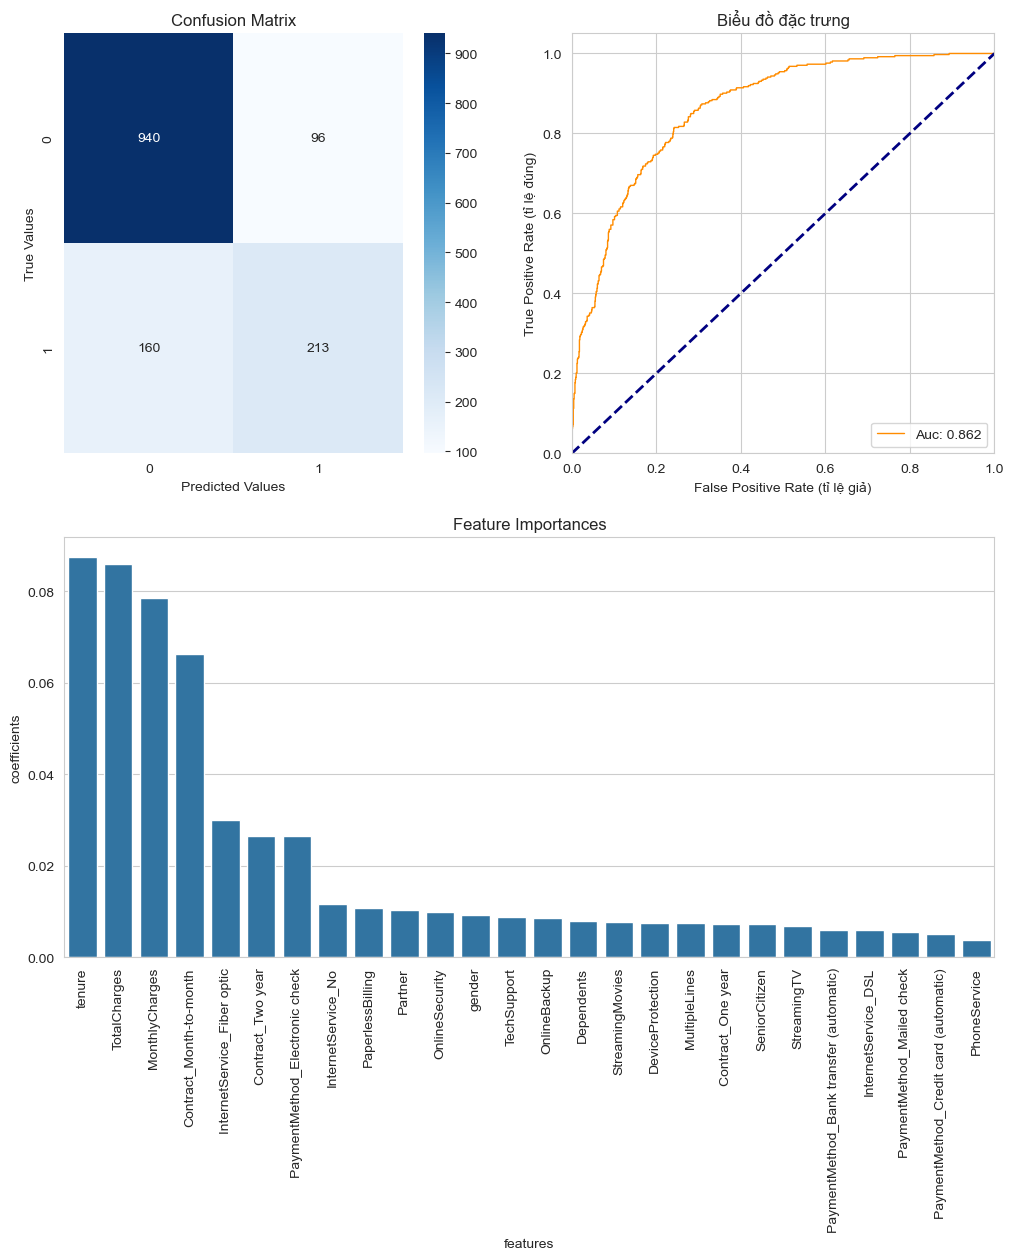

In [23]:
churn_prediction(rf_model, X_train_combined, y_train.values, X_test_combined, y_test.values, cols, cf = 'features')

GradientBoostingClassifier(min_samples_leaf=2, n_estimators=200,
                           random_state=42, subsample=0.8)

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88      1036
           1       0.68      0.56      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.75      1409
weighted avg       0.81      0.81      0.81      1409

Accuracy Score: 0.8133427963094393
Area under curve: 0.8584988665417619 

Churn rate (based on probabilities): 26.97%
Churn rate (based on predictions): 21.86%


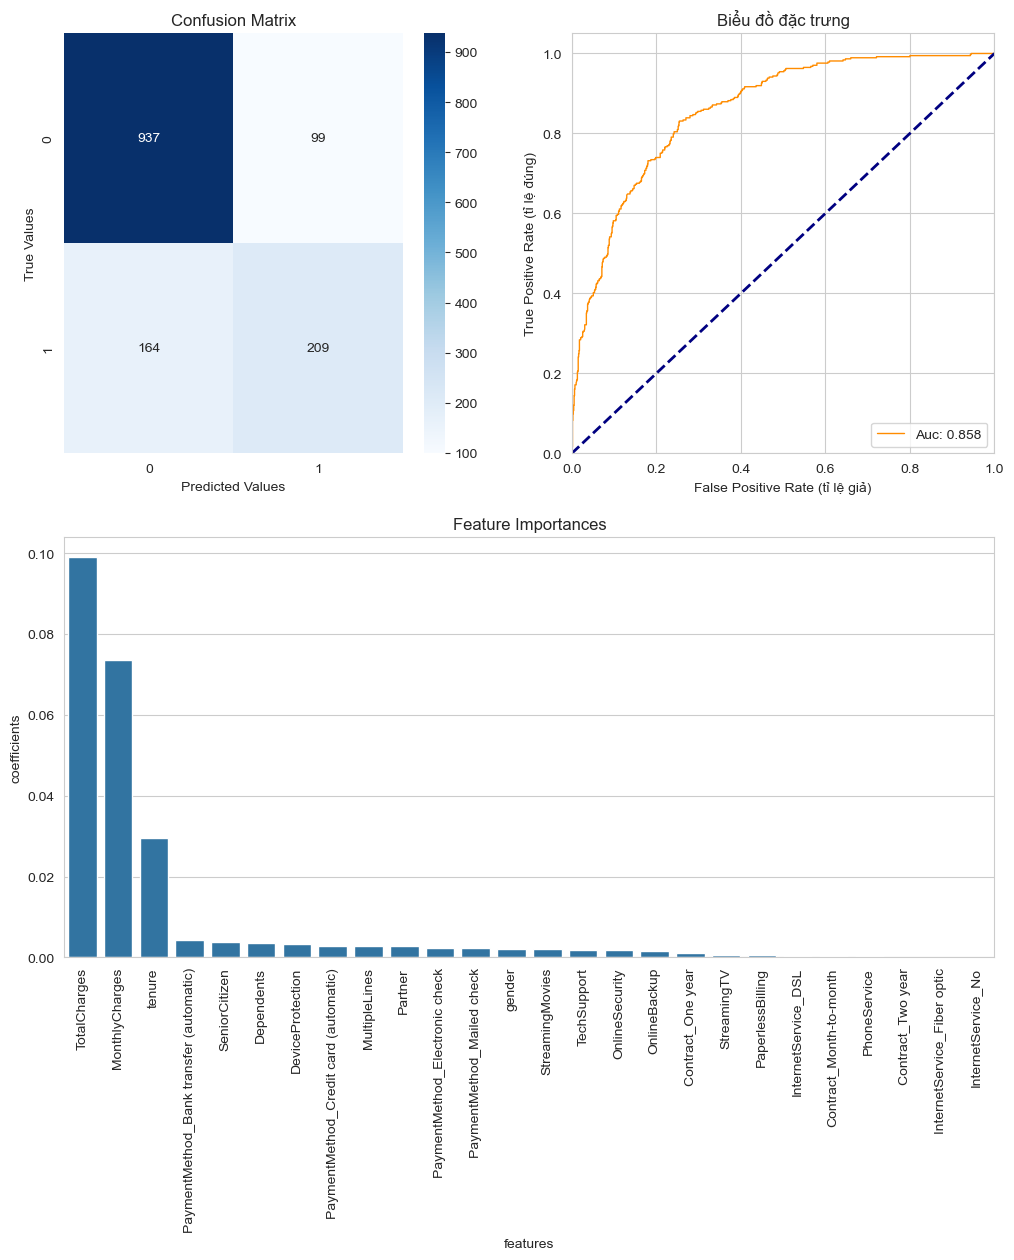

In [24]:
churn_prediction(gb_model, X_train_combined, y_train.values, X_test_combined, y_test.values, cols, cf = 'features')

In [25]:
import pandas as pd
import numpy as np
import plotly.express as px

# Dự đoán xác suất churn cho toàn bộ dataset
probabilities = voting_clf.predict_proba(X_test_combined)[:, 1]

# Tạo DataFrame chứa xác suất churn
results = pd.DataFrame({
    'churn_probability': probabilities
})

# Tạo các khoảng xác suất
bins = [i/10 for i in range(11)]  # [0.0, 0.05, 0.1, ..., 1.0]
labels = [f'{i*10}-{(i+1)*10}%' for i in range(10)]  # ['0-5%', '5-10%', ..., '95-100%']

# Phân loại xác suất vào các khoảng
results['probability_range'] = pd.cut(results['churn_probability'], bins=bins, labels=labels, include_lowest=True)

# Đếm số lượng khách hàng trong mỗi khoảng
count_by_range = results['probability_range'].value_counts().sort_index()

# Tính tổng số khách hàng
total_customers = len(results)
print(f"Tổng số khách hàng: {total_customers}")

# In kết quả
for range_label, count in count_by_range.items():
    (f"{range_label}: {count}")

# Tính phần trăm
percentage_by_range = (count_by_range / total_customers * 100).round(2)

for range_label, percentage in percentage_by_range.items():
    (f"{range_label}: {percentage}%")

# Tạo DataFrame cho bảng số liệu
stat_df = pd.DataFrame({
    'Khoảng xác suất rời bỏ': count_by_range.index,
    'Số lượng khách hàng': count_by_range,
    'Phần trăm khách hàng': percentage_by_range
})
stat_df = stat_df.reset_index(drop = True).set_index('Khoảng xác suất rời bỏ')
stat_df

Tổng số khách hàng: 1409


,Số lượng khách hàng,Phần trăm khách hàng
Khoảng xác suất rời bỏ,,
0-10%,530,37.62
10-20%,201,14.27
20-30%,170,12.07
30-40%,122,8.66
40-50%,79,5.61
50-60%,90,6.39
60-70%,95,6.74
70-80%,45,3.19
80-90%,60,4.26


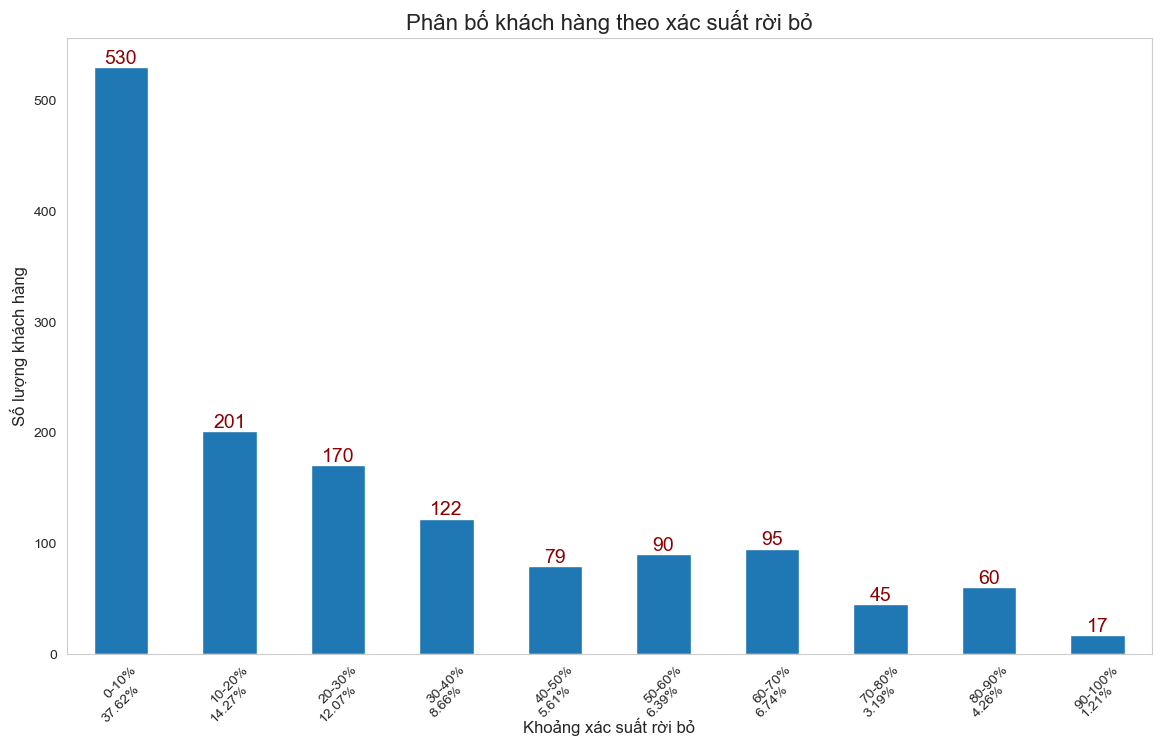

In [26]:
chart_data = pd.DataFrame({
    'Khoảng xác suất rời bỏ': count_by_range.index,
    'Số lượng khách hàng': count_by_range.values,
    'Phần trăm khách hàng': percentage_by_range.values
})

# Vẽ biểu đồ
plt.figure(figsize=(14, 8))
ax = count_by_range.plot(kind='bar')
plt.title('Phân bố khách hàng theo xác suất rời bỏ', fontsize=16)
plt.xlabel('Khoảng xác suất rời bỏ', fontsize=12)
plt.ylabel('Số lượng khách hàng', fontsize=12)
plt.xticks(rotation=45)
plt.grid(False) # Ẩn lưới để nhìn số liệu được rõ ràng hơn

# Thêm số lượng chi tiết trên đầu mỗi cột
for i, v in enumerate(count_by_range):
    ax.text(i, v, str(v), ha='center', va='bottom', color = 'darkred', fontsize = 14)

# Thêm phần trăm dưới nhãn trục x
for i, (range_label, percentage) in enumerate(percentage_by_range.items()):
    ax.text(i, -max(count_by_range)*0.05, f'{percentage}%', ha='center', va='top', rotation=45)

In [27]:
from matplotlib.patches import Circle, Wedge, Rectangle

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

def gauge(labels=['LOW','MEDIUM','HIGH','EXTREME'], \
          colors=['#007A00','#0063BF','#FFCC00','#ED1C24'], Probability=1, fname=False): 
    
    N = len(labels)
    colors = colors[::-1]

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(4)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, 'Churn Probability ' + np.round(Probability,2).astype(str), horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = (1-Probability)*180
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

In [28]:
# Gán x là khách hàng cần dự đoán (x là 1 index bất kì trong bảng test.csv, bắt đầu từ 0 - 1408)
x = 0

Actual value: [1]
Predicted probability of churning: 0.7984


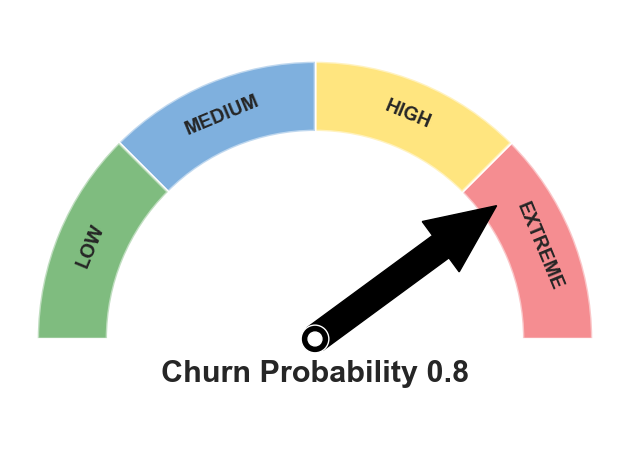

In [29]:
actual_value = y_test.values[x]
predicted_probability = rf_model.predict_proba(X_test_combined[x:x+1])[0, 1]
print(f"Actual value: {actual_value}")
print(f"Predicted probability of churning: {predicted_probability:.4f}")
gauge(Probability=predicted_probability)